# 04_TOPIC MODELLING_with LDA

## Цель

- провести topic modelling c `LDA` (Latent Dirichlet Allocation) с метрикой `coherence score`

## Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import logging

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import WordCloud

## Initialization

In [2]:
pd.set_option("display.max_colwidth", None)

plt.style.use("classic")
# Ignore UserWarning specifically
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
PROJECT_NAME = "finam_topic_modelling"
FILE_INPUT_NAME = "data_with_k_means.parquet"

# Get the current working directory
current_dir = Path.cwd()


# Traverse up to find "finam_text_classification" folder
project_root = current_dir
while project_root.name != PROJECT_NAME:
    if project_root.parent == project_root:  # Reached the filesystem root
        raise FileNotFoundError("The 'finam_text_classification' folder was not found.")
    project_root = project_root.parent

# Define the path to the input data relative to the project root
PTH_TO_INPUT_DATA = project_root / "data" / "interim" / FILE_INPUT_NAME

## Defs

In [4]:
def lda_model_gensim(corpus, dictionary, num_topics):
    from gensim import models

    ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, eval_every=20, num_topics=num_topics, passes=5)
    return ldamodel

In [5]:
def topic_file(topics_gensim_np, file_pth):
    list_topic = []
    for ind_topiс, topiс in enumerate(topics_gensim_np):
        list_word = topiс[1]
        for words in list_word:
            topic_word = []
            topic_word.append(ind_topiс)
            topic_word.append(words[0])
            topic_word.append(words[1])
            list_topic.append(topic_word)
    topic_gensim = pd.DataFrame(list_topic, columns=["topic", "word_in topic", "weight_topic"])
    topic_gensim.to_parquet(file_pth, index=False)
    return topic_gensim

In [6]:
# облако слов топиков для модели gensim
def plotWordCloud(topic_number, topics, head):
    """
    Строит визуализацию слов на основе текстов топиков из Gensim
    """
    # получаем частоты и слова топика
    text = dict(topics[topic_number][1])
    # print(head+str(topic_number))
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    #    wordcloud.generate(long_string)
    plt.figure(figsize=(15, 10))
    plt.title((head + " номер {}").format(topic_number))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

In [7]:
def get_topic(words, lda):
    """ """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0]))
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return [main_topic, main_probability]

## Main pipeline

### Read data

In [8]:
# Read data
try:
    # Use Path to check if the file exists
    if PTH_TO_INPUT_DATA.exists():
        # Read the Excel file
        df_init = pd.read_parquet(PTH_TO_INPUT_DATA)
        logging.info("File successfully loaded.")
    else:
        # Log an error if the file is not found
        logging.error(f"File not found: {PTH_TO_INPUT_DATA}")
except Exception as e:
    # Log any exceptions that occur
    logging.error(f"An error occurred: {e}")

In [9]:
df_init[["normalized_review_text"]].head(3).T

0  \
normalized_review_text  элегантный отель центр <loc> красивый стильный номер жуткий цена посещение отель рекомендоваться ограбить банк неожиданно разбогатеть это писать набрать <num> символ   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   1  \
normalized_review_text  стиль ваш поездка <loc> это шопинг <loc> молл созерцание фонтан гастрономический ужин пожалеть деньга усилить весь ощущение номер вид фонтан отель <org> это просто супер номер находиться нижний этаж <loc> поэтому вид фонтан оттуда точно хороший улица около хороший крыша это замечательный здание ресторан общий самый хороший прямо будильник заводить выходить смотреть фонтан балкон представление меняться течение вечер балкон курить мочь радовать расстаться привычка номер продавать сайт отель перекупщик тип <misc> номер увидеть реально работать удобный функциональный умный дом управление весь электроника номер <misc> дизайн просто привлекательный интересный очень функциональный сервис честные <num> <misc> мальчик этаж любой вопрос решаться моментально весь очень быстро ненавязчиво шопинг <loc> молл идти галерея ребята сотрудник отель помочь понести сумка отель отнести бояться доверять ценный груз смотровой площадка билет продаваться очередь прямо отель попасть <num> пройти галерея туда обратно контроль безопасность находиться сторона <loc> молл <loc> найти придраться весь вкусно сервис прекрасный общий вывод оказаться <loc> транзит вариант снова сюда   

                                                                                                                                                                                                                                                                                                                                                              2  
normalized_review_text  провести супруг уик енд <loc> самый люкс вид фонтан весь уровень отличный панорамный вид фонтан номер шикарный просторный стильный весь чувствоваться качество люкс номер бесплатно предоставить бентли водитель завтрак отличный безупречный спа прекрасный фитнес общий недостаток кроме отель городской море рядом маленький бассейн

### Make ls from normalized words

In [10]:
df_init["ls_normalized_text"] = df_init["normalized_review_text"].apply(lambda x: x.split())
df_init[["ls_normalized_text"]].head(3)

ls_normalized_text
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [элегантный, отель, центр, <loc>, красивый, стильный, номер, жуткий, цена, посещение, отель, рекомендоваться, ограбить, банк, неожиданно, разбогатеть, это, писать, набрать, <num>, символ]
1  [стиль, ваш, поездка, <loc>, это, шопинг, <loc>, молл, созерцание, фонтан, гастрономический, ужин, пожалеть, деньга, усилить, весь, ощущение, номер, вид, фонтан, отель, <org>, это, просто, супер, номер, находиться, нижний, этаж, <loc>, поэтому, вид, фонтан, оттуда, точно, хороший, улица, около, хороший, крыша, это, замечательный, здание, ресторан, общий, самый, хороший, прямо, будильник, заводить, выходить, смотреть, фонтан, балкон, представление, меняться, течение, вечер, балкон, курить, мочь, радовать, расстаться, привычка, номер, продавать, сайт, отель, перекупщик, тип, <misc>, номер, увидеть, реально, работать, удобный, функциональный, умный, дом, управление, весь, электроника, номер, <misc>, дизайн, просто, привлекательный, интересный, очень, функциональный, сервис, честные, <num>, <misc>, мальчик, этаж, любой, вопрос, решаться, моментально, ...]
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [провести, супруг, уик, енд, <loc>, самый, люкс, вид, фонтан, весь, уровень, отличный, панорамный, вид, фонтан, номер, шикарный, просторный, стильный, весь, чувствоваться, качество, люкс, номер, бесплатно, предоставить, бентли, водитель, завтрак, отличный, безупречный, спа, прекрасный, фитнес, общий, недостаток, кроме, отель, городской, море, рядом, маленький, бассейн]

### Using BOW with gensim

In [11]:
import gensim
from gensim import corpora, models

In [12]:
type(df_init["ls_normalized_text"].values)

numpy.ndarray

In [13]:
dictionary = gensim.corpora.Dictionary(df_init["ls_normalized_text"].values)  # составляем словарь из терминов
print("Размер словаря до фильтрации: {}".format(len(dictionary)))

Размер словаря до фильтрации: 18650


In [14]:
dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=3 * 10**6)  # практически не фильтрует
dictionary.compactify()  # reassign id
print("Размер словаря после фильтрации: {}".format(len(dictionary)))

Размер словаря после фильтрации: 6975


In [15]:
print(dictionary)

Dictionary<6975 unique tokens: ['банк', 'жуткий', 'красивый', 'набрать', 'неожиданно']...>


In [16]:
corpus = [dictionary.doc2bow(text) for text in df_init["ls_normalized_text"]]
type(corpus), corpus[1:3]

(list,
 [[(12, 3),
   (13, 1),
   (14, 2),
   (15, 1),
   (16, 1),
   (17, 1),
   (18, 1),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 2),
   (24, 1),
   (25, 1),
   (26, 1),
   (27, 1),
   (28, 2),
   (29, 1),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 1),
   (34, 1),
   (35, 1),
   (36, 1),
   (37, 1),
   (38, 1),
   (39, 1),
   (40, 1),
   (41, 1),
   (42, 1),
   (43, 1),
   (44, 3),
   (45, 1),
   (46, 1),
   (47, 1),
   (48, 2),
   (49, 1),
   (50, 1),
   (51, 1),
   (52, 2),
   (53, 1),
   (54, 1),
   (55, 1),
   (56, 1),
   (57, 1),
   (58, 1),
   (59, 1),
   (60, 1),
   (61, 1),
   (62, 1),
   (63, 1),
   (64, 1),
   (65, 1),
   (66, 1),
   (67, 1),
   (68, 1),
   (69, 1),
   (70, 1),
   (71, 1),
   (72, 1),
   (73, 1),
   (74, 2),
   (75, 2),
   (76, 1),
   (77, 1),
   (78, 1),
   (79, 1),
   (80, 1),
   (81, 1),
   (82, 1),
   (83, 1),
   (84, 2),
   (85, 1),
   (86, 1),
   (87, 1),
   (88, 1),
   (89, 1),
   (90, 1),
   (91, 1),
   (92, 1),
   (93, 1),
   (94, 1

### Bi-Gram BOW with gensim

In [ ]:
texts = df_init["ls_normalized_text"]

# 1. Создаем биграммы


bigram = models.Phrases(texts, min_count=3, threshold=5)  # Обучает биграммы


bigram_phraser = models.phrases.Phraser(bigram)  # Применяет биграммы к предложению

# 2. Применяем биграммы к текстам
bigram_texts = [bigram_phraser[sent] for sent in texts]

# 3. Создаем триграммы на основе биграммного текста
trigram = models.Phrases(bigram_texts, min_count=2, threshold=5)
trigram_phraser = models.phrases.Phraser(trigram)

# 4. Применяем триграммы
trigram_texts = [trigram_phraser[sent] for sent in bigram_texts]


bigram_dict = corpora.Dictionary(bigram_texts)  # составляем словарь из терминов с учетом биграмм слов предлжений


print("Размер словаря до фильтрации: {}".format(len(bigram_dict)))

trigram_dict = corpora.Dictionary(trigram_texts)  # составляем словарь из терминов с учетом биграмм слов предлжений
print("Размер словаря до фильтрации: {}".format(len(trigram_dict)))

Размер словаря до фильтрации: 22921
Размер словаря до фильтрации: 26774


In [18]:
bigram_texts[:3]

[['элегантный',
  'отель',
  'центр',
  '<loc>',
  'красивый_стильный',
  'номер',
  'жуткий',
  'цена',
  'посещение',
  'отель',
  'рекомендоваться',
  'ограбить',
  'банк',
  'неожиданно',
  'разбогатеть',
  'это',
  'писать',
  'набрать',
  '<num>_символ'],
 ['стиль',
  'ваш',
  'поездка',
  '<loc>',
  'это',
  'шопинг',
  '<loc>_молл',
  'созерцание',
  'фонтан',
  'гастрономический',
  'ужин',
  'пожалеть',
  'деньга',
  'усилить',
  'весь',
  'ощущение',
  'номер',
  'вид',
  'фонтан',
  'отель',
  '<org>',
  'это',
  'просто_супер',
  'номер',
  'находиться',
  'нижний_этаж',
  '<loc>',
  'поэтому',
  'вид',
  'фонтан',
  'оттуда',
  'точно',
  'хороший',
  'улица',
  'около',
  'хороший',
  'крыша',
  'это',
  'замечательный',
  'здание',
  'ресторан',
  'общий',
  'самый_хороший',
  'прямо',
  'будильник',
  'заводить',
  'выходить',
  'смотреть',
  'фонтан',
  'балкон',
  'представление',
  'меняться',
  'течение',
  'вечер',
  'балкон',
  'курить',
  'мочь_радовать',
  'рас

In [19]:
trigram_texts[:3]

[['элегантный',
  'отель',
  'центр_<loc>',
  'красивый_стильный',
  'номер',
  'жуткий',
  'цена',
  'посещение',
  'отель',
  'рекомендоваться',
  'ограбить',
  'банк',
  'неожиданно',
  'разбогатеть',
  'это',
  'писать',
  'набрать',
  '<num>_символ'],
 ['стиль',
  'ваш',
  'поездка',
  '<loc>',
  'это',
  'шопинг',
  '<loc>_молл',
  'созерцание',
  'фонтан',
  'гастрономический',
  'ужин',
  'пожалеть',
  'деньга',
  'усилить',
  'весь',
  'ощущение',
  'номер',
  'вид_фонтан',
  'отель',
  '<org>',
  'это',
  'просто_супер',
  'номер',
  'находиться',
  'нижний_этаж',
  '<loc>',
  'поэтому',
  'вид_фонтан',
  'оттуда',
  'точно',
  'хороший',
  'улица',
  'около',
  'хороший',
  'крыша',
  'это',
  'замечательный',
  'здание',
  'ресторан',
  'общий',
  'самый_хороший',
  'прямо',
  'будильник',
  'заводить',
  'выходить',
  'смотреть',
  'фонтан',
  'балкон',
  'представление',
  'меняться',
  'течение',
  'вечер',
  'балкон_курить',
  'мочь_радовать',
  'расстаться',
  'привычк

In [20]:
bigram_dict.filter_extremes(no_below=3, no_above=0.4, keep_n=3 * 10**6)
print("Размер словаря после фильтрации: {}".format(len(bigram_dict)))

trigram_dict.filter_extremes(no_below=3, no_above=0.4, keep_n=3 * 10**6)
print("Размер словаря после фильтрации: {}".format(len(trigram_dict)))

Размер словаря после фильтрации: 10908
Размер словаря после фильтрации: 14181


In [21]:
corpus_bi = [
    bigram_dict.doc2bow(text) for text in bigram_texts
]  # составляем корпус документов по словарю полученному с использованием биграмм

corpus_tri = [
    trigram_dict.doc2bow(text) for text in trigram_texts
]  # составляем корпус документов по словарю полученному с использованием биграмм

In [22]:
print(dictionary)
print(bigram_dict)
print(trigram_dict)

Dictionary<6975 unique tokens: ['банк', 'жуткий', 'красивый', 'набрать', 'неожиданно']...>
Dictionary<10908 unique tokens: ['<num>_символ', 'банк', 'жуткий', 'красивый_стильный', 'набрать']...>
Dictionary<14181 unique tokens: ['<num>_символ', 'банк', 'жуткий', 'красивый_стильный', 'набрать']...>


## Топики на основании модели Latent Dirichlet allocation (LDA)

100%|██████████| 6/6 [02:04<00:00, 20.78s/it]


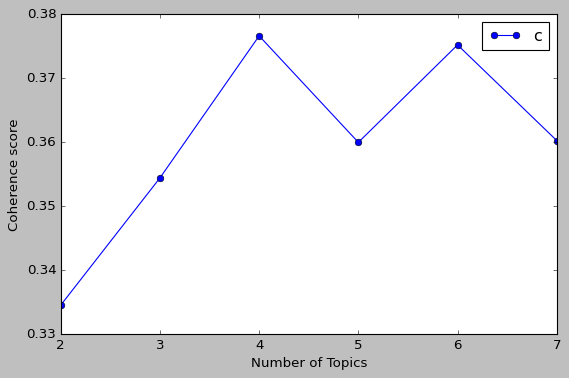

Best number of topics: 4


In [23]:
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from tqdm import tqdm

coherence_values = []
best_model = None
best_coherence = -np.inf
best_number_of_topics = None

topic_range = range(2, 8, 1)

for num_topics in tqdm(topic_range):
    model = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=5,  # More passes improve topic coherence
        random_state=42,
    )  # Train LDA model

    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")

    coherence_values.append(coherencemodel.get_coherence())

    if coherence_values[-1] > best_coherence:
        best_coherence = coherence_values[-1]
        best_model = model
        best_number_of_topics = num_topics

# Plot the coherence scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_values, marker="o", label="c")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

print(f"Best number of topics: {best_number_of_topics}")

100%|██████████| 6/6 [02:04<00:00, 20.76s/it]


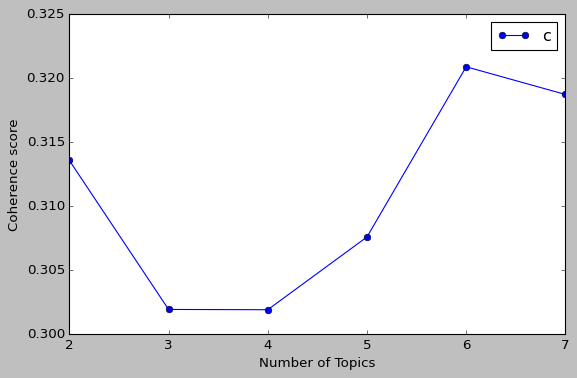

Best number of topics for bigram: 6


In [29]:
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from tqdm import tqdm

coherence_values = []
best_model = None
best_coherence = -np.inf
best_number_of_topics = None

topic_range = range(2, 8, 1)

for num_topics in tqdm(topic_range):
    model = LdaModel(
        corpus=corpus_bi,
        num_topics=num_topics,
        id2word=bigram_dict,
        passes=5,  # More passes improve topic coherence
        random_state=42,
    )  # Train LDA model

    coherencemodel = CoherenceModel(model=model, texts=bigram_texts, dictionary=bigram_dict, coherence="c_v")

    coherence_values.append(coherencemodel.get_coherence())

    if coherence_values[-1] > best_coherence:
        best_coherence = coherence_values[-1]
        best_model = model
        best_number_of_topics = num_topics

# Plot the coherence scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_values, marker="o", label="c")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

print(f"Best number of topics for bigram: {best_number_of_topics}")

100%|██████████| 6/6 [02:02<00:00, 20.44s/it]


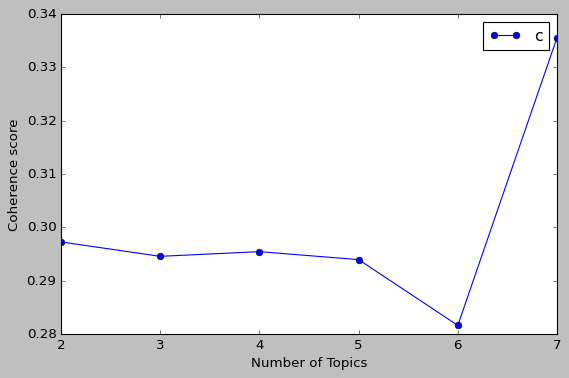

Best number of topics for trigram: 7


In [30]:
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from tqdm import tqdm

coherence_values = []
best_model = None
best_coherence = -np.inf
best_number_of_topics = None

topic_range = range(2, 8, 1)

for num_topics in tqdm(topic_range):
    model = LdaModel(
        corpus=corpus_tri,
        num_topics=num_topics,
        id2word=trigram_dict,
        passes=5,  # More passes improve topic coherence
        random_state=42,
    )  # Train LDA model

    coherencemodel = CoherenceModel(model=model, texts=trigram_texts, dictionary=trigram_dict, coherence="c_v")

    coherence_values.append(coherencemodel.get_coherence())

    if coherence_values[-1] > best_coherence:
        best_coherence = coherence_values[-1]
        best_model = model
        best_number_of_topics = num_topics

# Plot the coherence scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_values, marker="o", label="c")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

print(f"Best number of topics for trigram: {best_number_of_topics}")

100%|██████████| 6/6 [01:59<00:00, 20.00s/it]


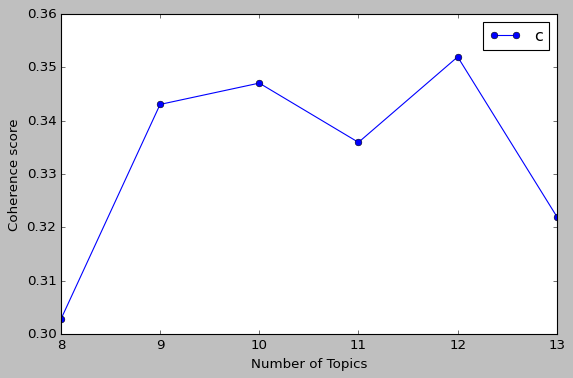

Best number of topics for trigram: 12


In [31]:
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from tqdm import tqdm

coherence_values = []
best_model = None
best_coherence = -np.inf
best_number_of_topics = None

topic_range = range(8, 14, 1)

for num_topics in tqdm(topic_range):
    model = LdaModel(
        corpus=corpus_tri,
        num_topics=num_topics,
        id2word=trigram_dict,
        passes=5,  # More passes improve topic coherence
        random_state=42,
    )  # Train LDA model

    coherencemodel = CoherenceModel(model=model, texts=trigram_texts, dictionary=trigram_dict, coherence="c_v")

    coherence_values.append(coherencemodel.get_coherence())

    if coherence_values[-1] > best_coherence:
        best_coherence = coherence_values[-1]
        best_model = model
        best_number_of_topics = num_topics

# Plot the coherence scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_values, marker="o", label="c")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

print(f"Best number of topics for trigram: {best_number_of_topics}")

количество топиков возьмем 7

In [ ]:
number_topics_un = 4
number_topics_bi = 6
number_topics_tri = 12


ldamodel_un = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=number_topics_un, passes=5)



ldamodel_bi = models.ldamodel.LdaModel(corpus_bi, id2word=bigram_dict, num_topics=number_topics_bi, passes=5)
ldamodel_tri = models.ldamodel.LdaModel(corpus_tri, id2word=trigram_dict, num_topics=number_topics_tri, passes=5)

In [33]:
## получение топиков
topics_gensim_un = ldamodel_un.show_topics(num_topics=number_topics_un, num_words=100, formatted=False)
topics_gensim_bi = ldamodel_bi.show_topics(num_topics=number_topics_bi, num_words=100, formatted=False)
topics_gensim_tri = ldamodel_tri.show_topics(num_topics=number_topics_tri, num_words=100, formatted=False)

topics_un = pd.DataFrame(topics_gensim_un)
topics_un.columns = ["topic num", "topic_word"]

topics_bi = pd.DataFrame(topics_gensim_bi)
topics_bi.columns = ["topic num", "topic_word"]

topics_tri = pd.DataFrame(topics_gensim_tri)
topics_tri.columns = ["topic num", "topic_word"]

### Vizualization

In [34]:
vis_un = gensimvis.prepare(ldamodel_un, corpus, dictionary)
vis_bi = gensimvis.prepare(ldamodel_bi, corpus_bi, bigram_dict)
vis_tri = gensimvis.prepare(ldamodel_tri, corpus_tri, trigram_dict)

pyLDAvis.enable_notebook()

In [35]:
vis_un

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.131706  0.056689       1        1  27.419337
1     -0.078603 -0.064589       2        1  24.495376
2     -0.104329  0.083237       3        1  24.405897
3      0.051225 -0.075336       4        1  23.679391, topic_info=            Term         Freq        Total Category  logprob  loglift
235        метро  2224.000000  2224.000000  Default  30.0000  30.0000
369       минута  1997.000000  1997.000000  Default  29.0000  29.0000
169     персонал  2950.000000  2950.000000  Default  28.0000  28.0000
125     отличный  1677.000000  1677.000000  Default  27.0000  27.0000
108      хороший  3519.000000  3519.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
100      удобный   350.486418  1995.015373   Topic4  -5.4257  -0.2985
361      большой   279.213830  1327.765289   Topic4  -5.6530  -0.1187
169     персонал   305.720063  2950.168494   Topic4  -5.5624  -0.8264
198  понравиться   257.765961  1552.869444   Topic4  -5.7330  -0.3552
138        <per>   256.234256  1971.729047   Topic4  -5.7389  -0.6000

[371 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1065      1  0.157425       10
1065      2  0.783845       10
1065      3  0.003280       10
1065      4  0.055755       10
1109      1  0.034273       15
...     ...       ...      ...
910       2  0.913744  яичница
910       4  0.038393  яичница
1976      1  0.026486     яйцо
1976      2  0.874034     яйцо
1976      4  0.099322     яйцо

[835 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [36]:
vis_bi

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.025744  0.000915       1        1  29.815716
1     -0.202403 -0.088547       2        1  17.519602
0      0.111973 -0.094536       3        1  17.195801
5      0.121562  0.020176       4        1  13.731803
2      0.028904  0.035601       5        1  12.245211
4     -0.085781  0.126392       6        1   9.491867, topic_info=                 Term         Freq        Total Category  logprob  loglift
13              <num>  4344.000000  4344.000000  Default  30.0000  30.0000
104           хороший  3134.000000  3134.000000  Default  29.0000  29.0000
121          отличный  1278.000000  1278.000000  Default  28.0000  28.0000
1793                –   392.000000   392.000000  Default  27.0000  27.0000
165          персонал  1582.000000  1582.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
230   останавливаться    78.561882   635.162711   Topic6  -5.8864   0.2647
192       понравиться    84.789020   929.947434   Topic6  -5.8102  -0.0402
121          отличный    88.903845  1278.591897   Topic6  -5.7628  -0.3112
413      расположение    88.291502  1241.677152   Topic6  -5.7697  -0.2888
363             место    85.818742  1080.688290   Topic6  -5.7981  -0.1784

[537 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2919      3  0.198790     01
2919      4  0.795159     01
1237      4  0.982483     09
8425      6  0.947612  11_00
6900      4  0.967989   2012
...     ...       ...    ...
1793      1  0.005101      –
1793      2  0.002551      –
1793      3  0.020406      –
1793      4  0.964182      –
1793      5  0.005101      –

[1250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 6, 3, 5])

In [37]:
vis_tri

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.146653  0.047938       1        1  28.033273
5     -0.172540  0.017960       2        1  12.317420
7     -0.052124 -0.083848       3        1  11.816943
6     -0.019952 -0.120089       4        1  10.674446
10     0.048250 -0.067009       5        1  10.392995
1     -0.076535  0.040398       6        1   6.799575
9     -0.062807 -0.013196       7        1   4.563142
2      0.107604 -0.092453       8        1   3.889391
3      0.077860  0.021547       9        1   3.685765
11     0.058232 -0.055432      10        1   3.294508
0     -0.012215  0.212684      11        1   2.964313
4      0.250881  0.091499      12        1   1.568228, topic_info=                       Term         Freq        Total Category  logprob  \
13                    <num>  3108.000000  3108.000000  Default  30.0000   
1888                      –   440.000000   440.000000  Default  29.0000   
119                отличный   967.000000   967.000000  Default  28.0000   
102                 хороший  2343.000000  2343.000000  Default  27.0000   
303           рекомендовать   601.000000   601.000000  Default  26.0000   
...                     ...          ...          ...      ...      ...   
2812  разнообразный_завтрак    13.680999    48.057362  Topic12  -5.7581   
1806                спасибо    17.699402   346.366141  Topic12  -5.5005   
547                посетить    14.719961   109.897383  Topic12  -5.6849   
63               прекрасный    16.298226   464.150177  Topic12  -5.5830   
226         останавливаться    14.642204   465.905068  Topic12  -5.6902   

      loglift  
13    30.0000  
1888  29.0000  
119   28.0000  
102   27.0000  
303   26.0000  
...       ...  
2812   2.8988  
1806   1.1813  
547    2.1449  
63     0.8061  
226    0.6951  

[913 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
3192       5  0.147774             01
3192       6  0.797981             01
3192       8  0.029555             01
11323      8  0.977559             07
7373      10  0.946987          10_00
...      ...       ...            ...
11        11  0.021529            это
11        12  0.000574            это
11003      9  0.917924  яичница_омлет
1888       1  0.002271              –
1888       6  0.996757              –

[2467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 8, 7, 11, 2, 10, 3, 4, 12, 1, 5])

In [ ]:
topics_gensim_base_np = topics_base.values
topics_gensim_bi_np = topics_bi.values

In [43]:
topic_gensim_bi.head()

topic word_in topic  weght_topic
0      0         очень     0.020411
1      0       завтрак     0.014272
2      0       хороший     0.011491
3      0     гостиница     0.011312
4      0         <num>     0.007953

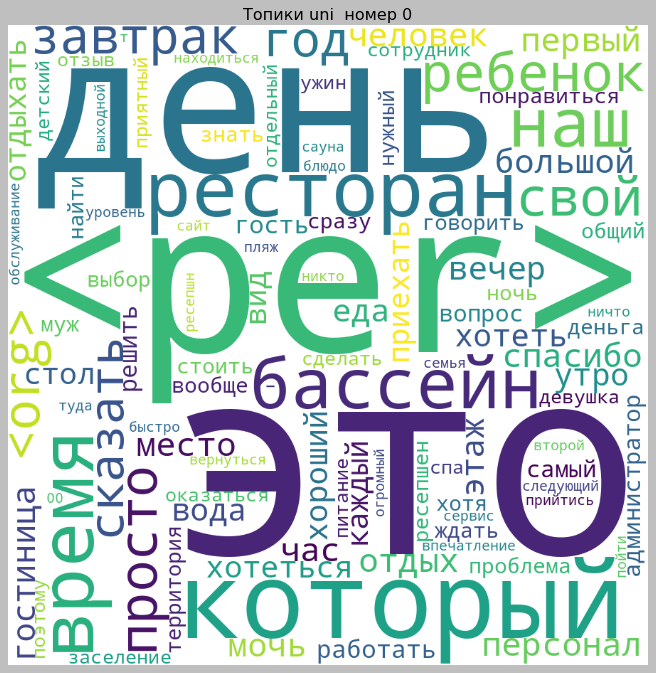

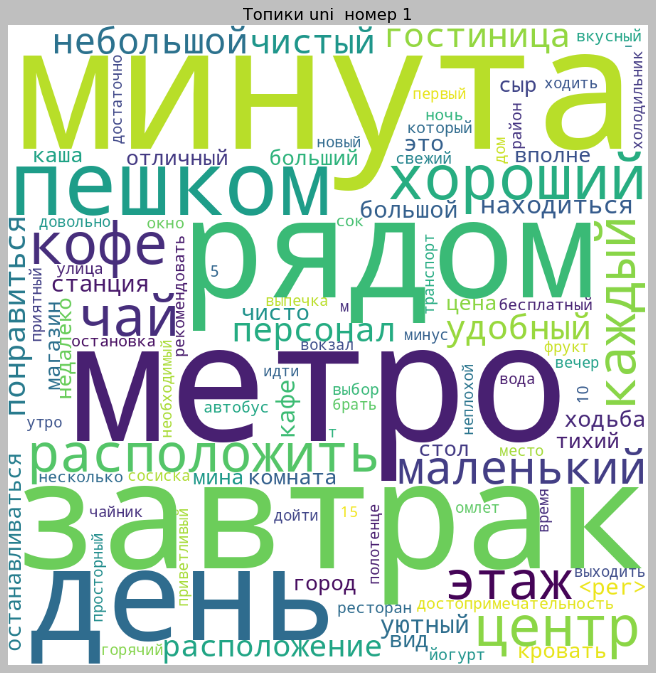

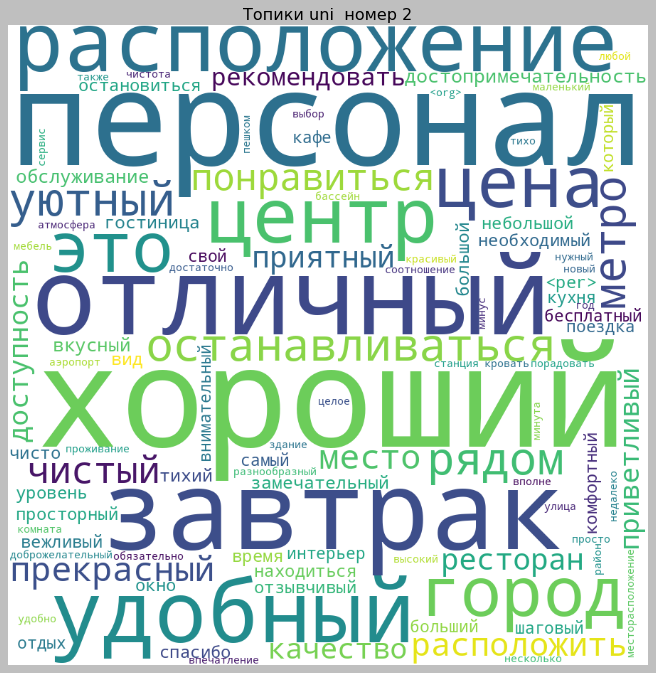

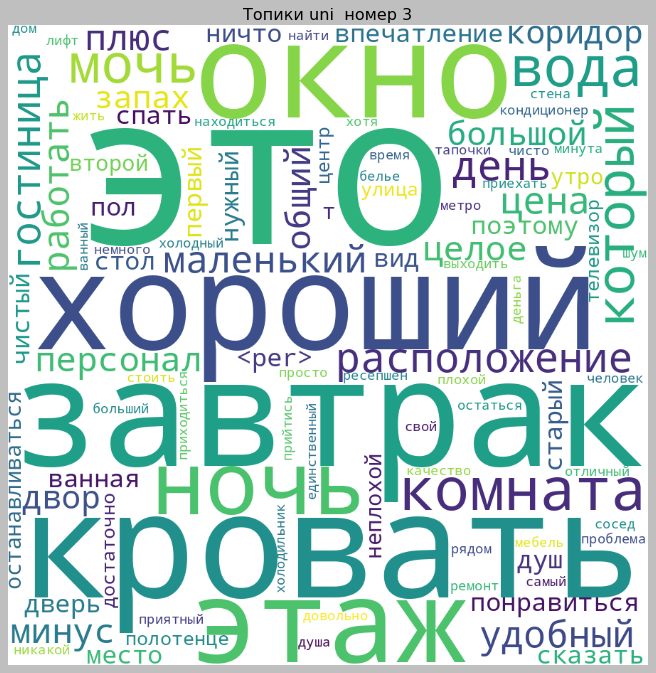

In [42]:
for i in range(4):
    plotWordCloud(topic_number=i, topics=topics_gensim_un, head="Топики uni ")

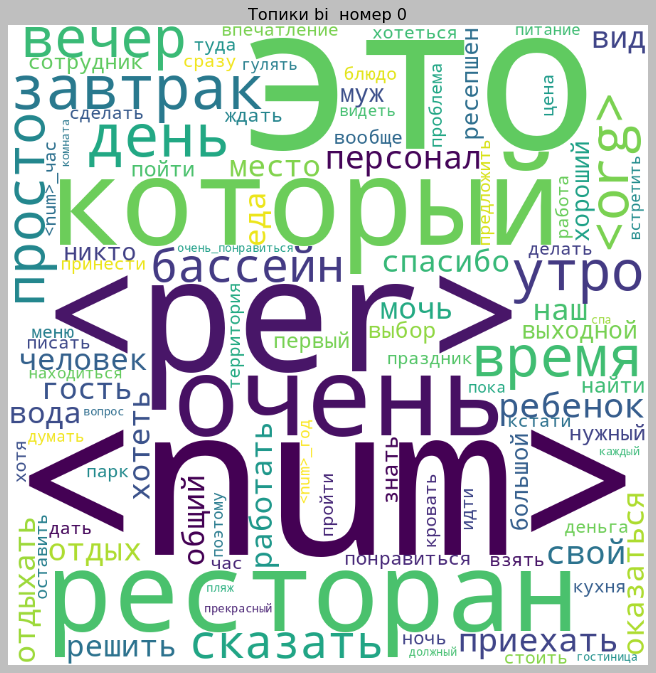

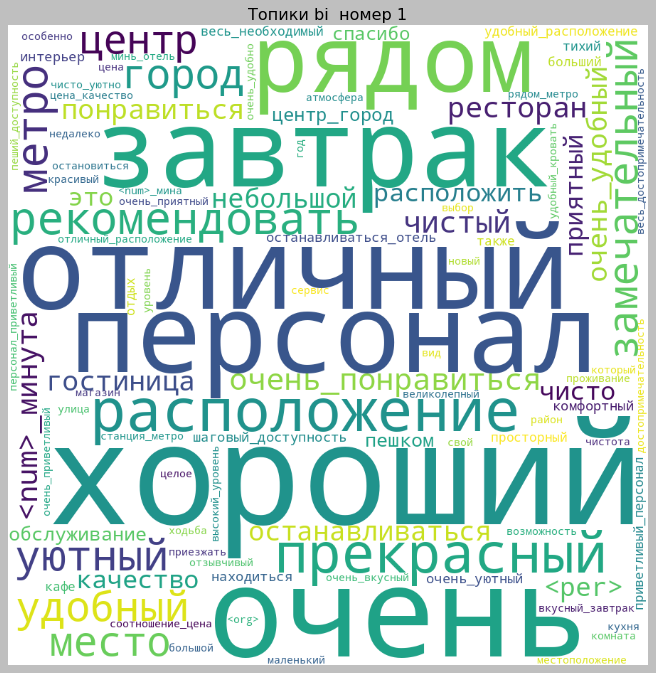

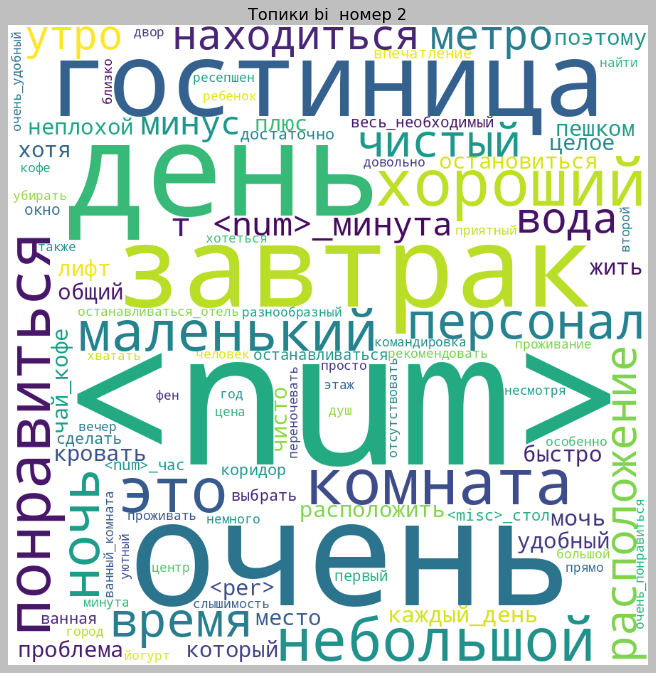

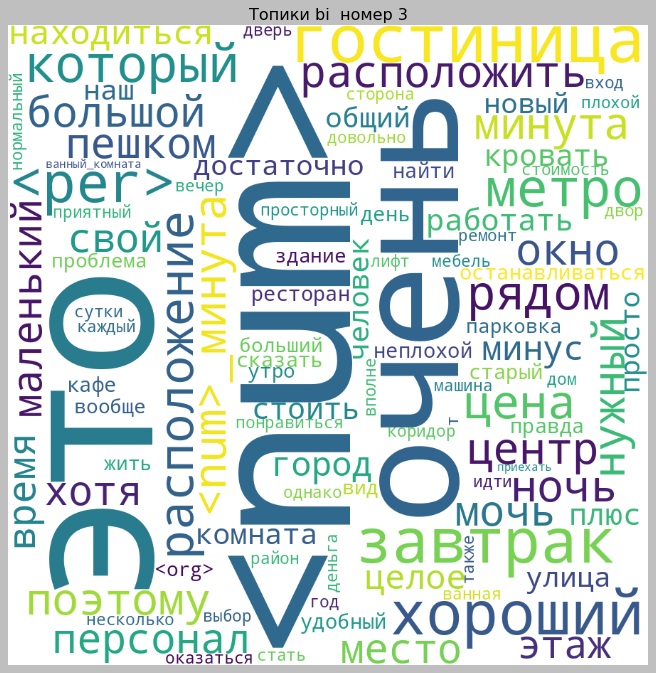

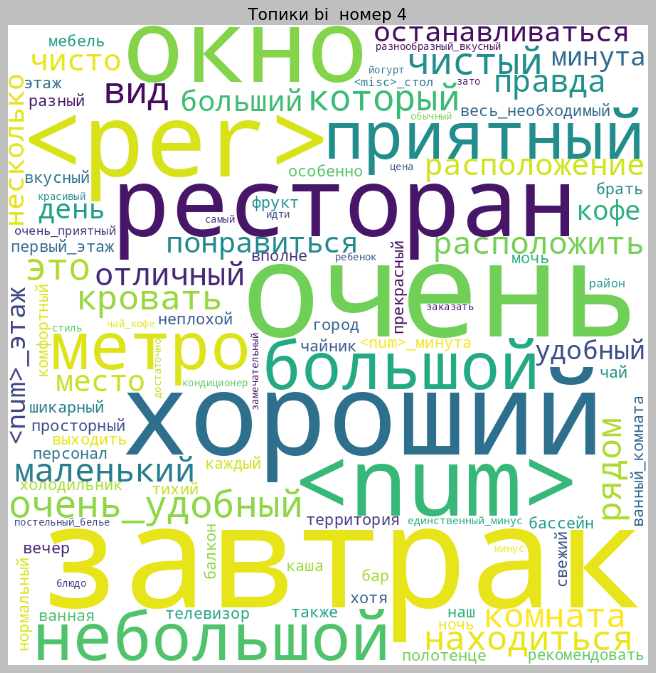

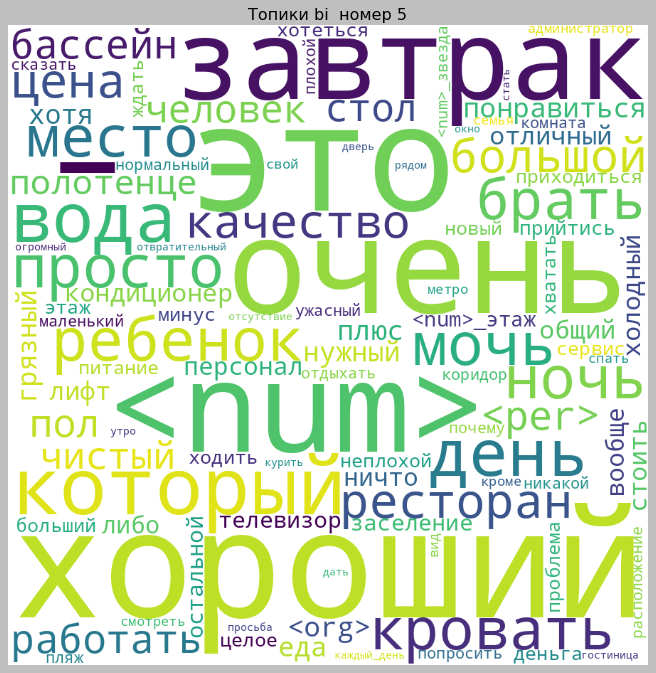

In [43]:
for i in range(6):
    plotWordCloud(topic_number=i, topics=topics_gensim_bi, head="Топики bi ")

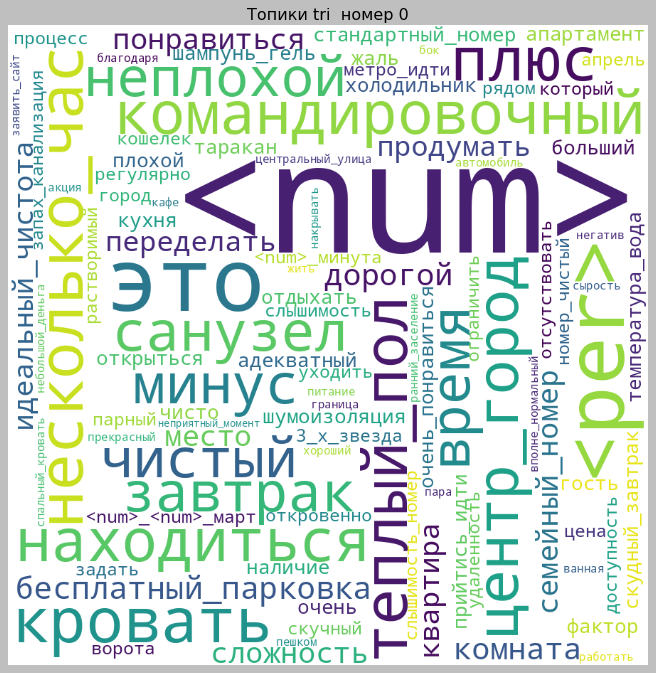

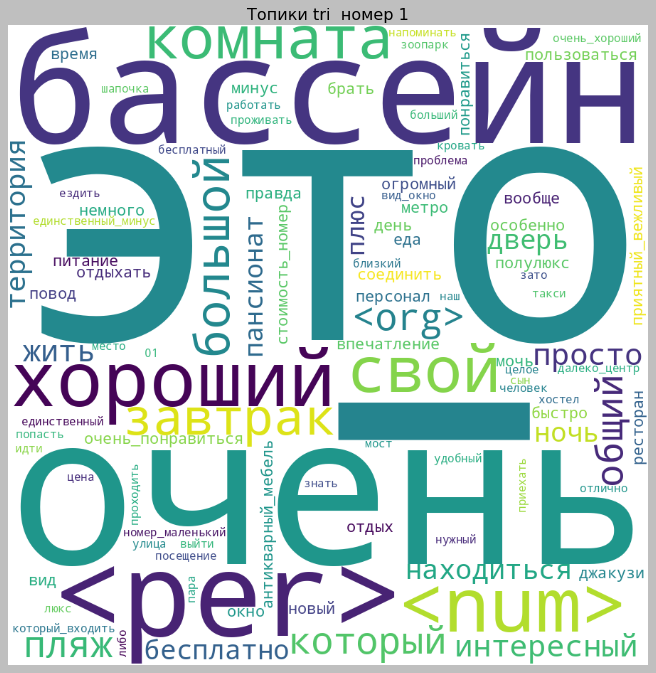

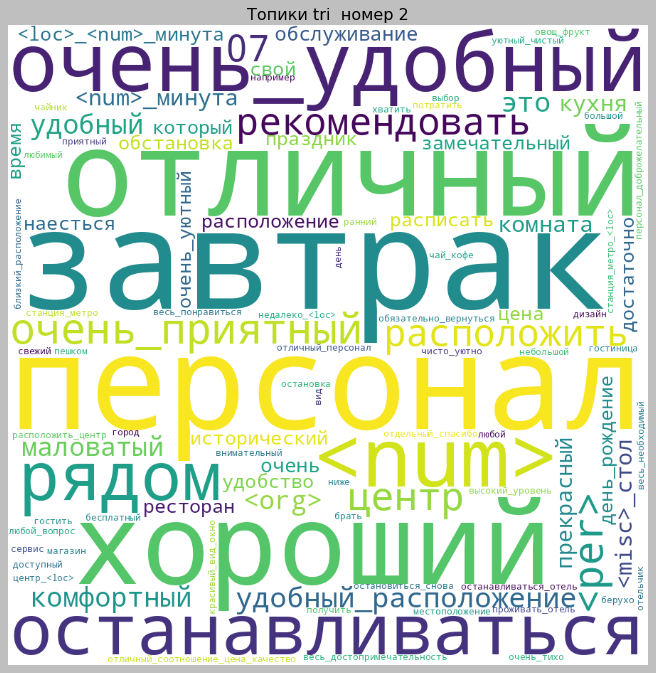

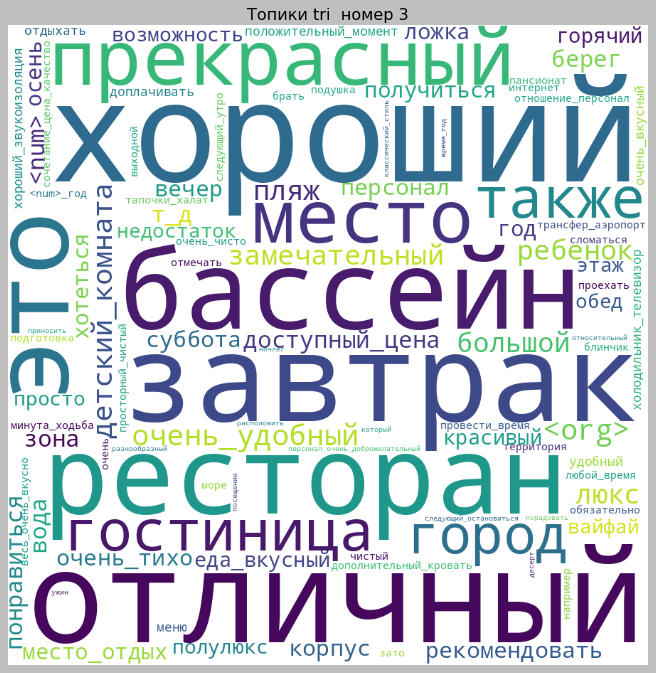

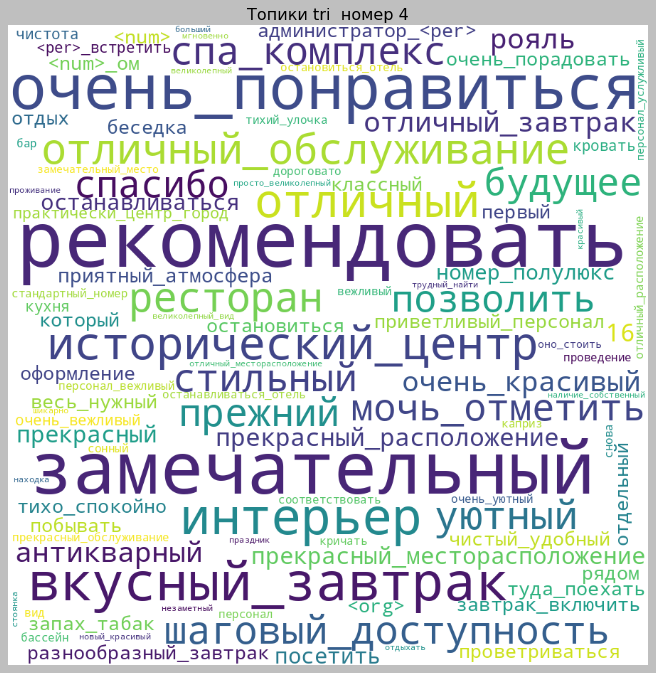

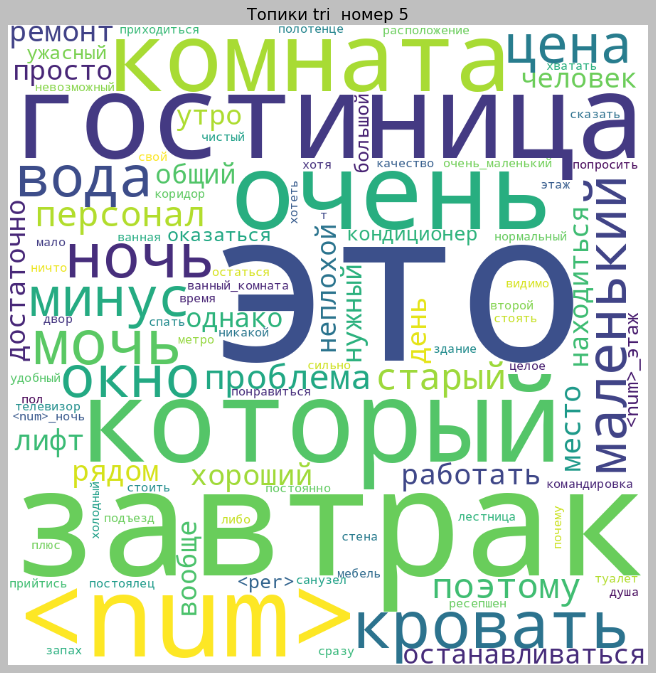

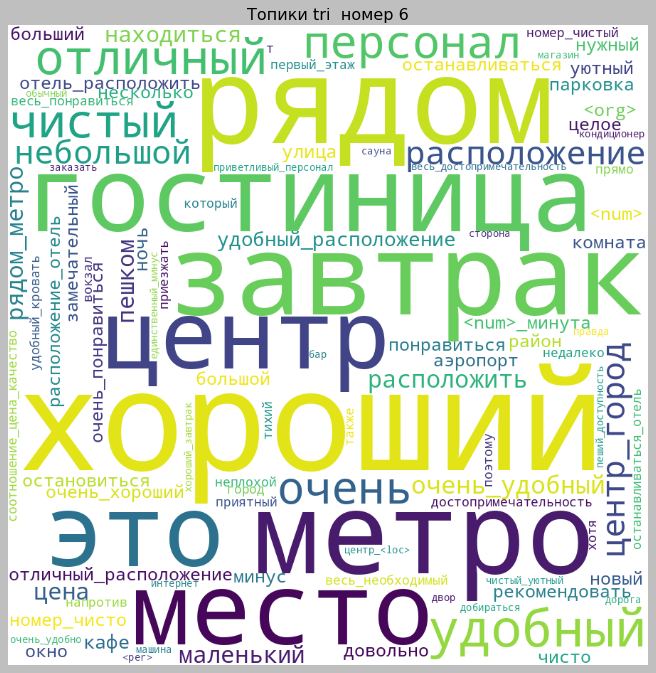

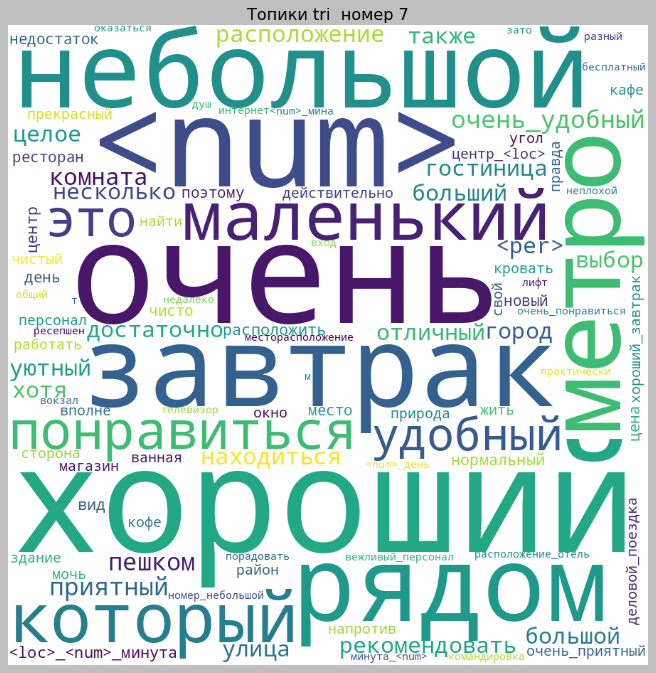

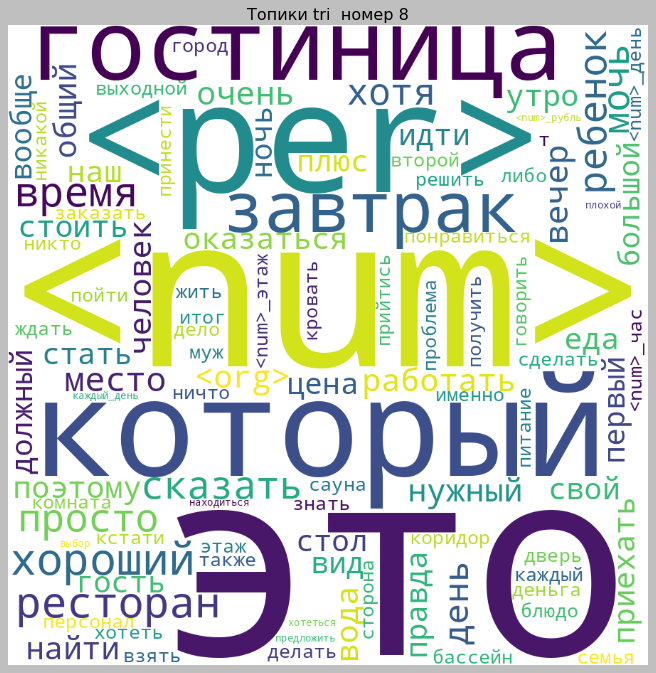

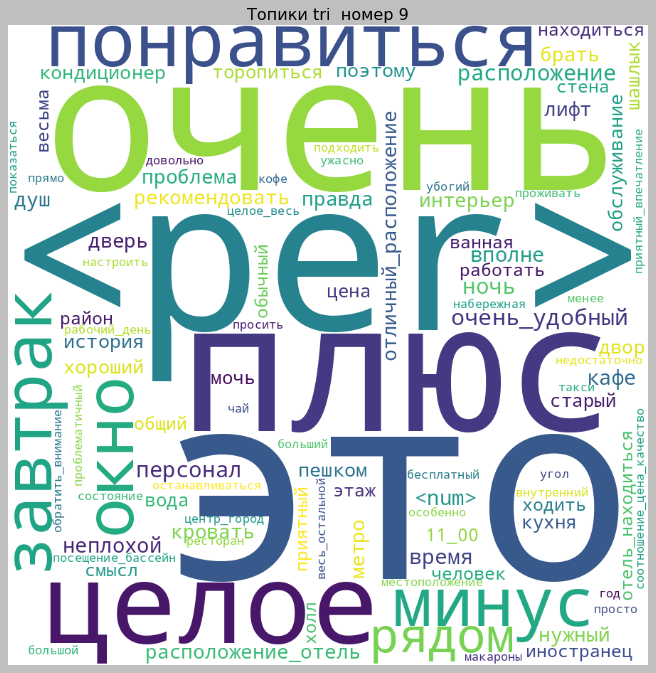

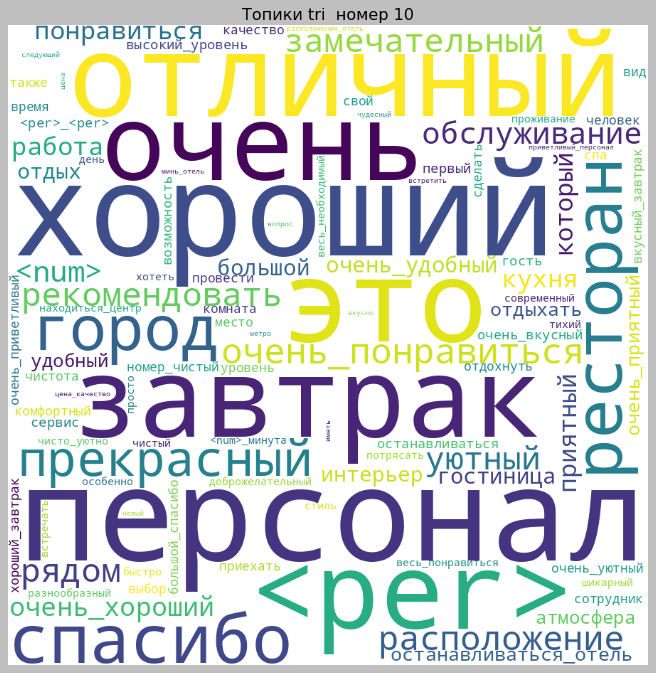

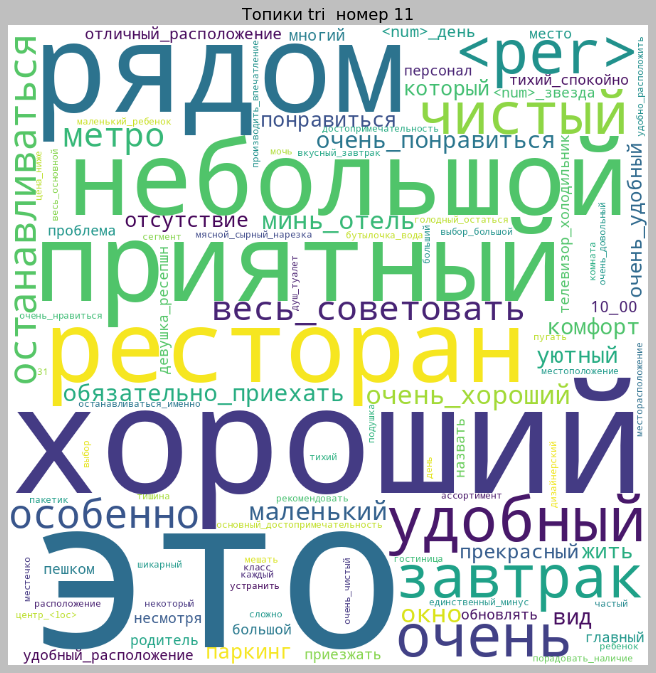

In [45]:
for i in range(12):
    plotWordCloud(topic_number=i, topics=topics_gensim_tri, head="Топики tri ")

## Назначим каждому документу наиболее подходящий (наиболее вероятный) для него топик, для каждой из моделей(base и bi).

In [47]:
df_init["lda_un"] = df_init["ls_normalized_text"].apply(get_topic, lda=ldamodel_un)
df_init["topic_un"] = df_init["lda_un"].str[0]
df_init["probability_un"] = df_init["lda_un"].str[1]


df_init["lda_bi"] = df_init["ls_normalized_text"].apply(get_topic, lda=ldamodel_bi)
df_init["topic_bi"] = df_init["lda_bi"].str[0]
df_init["probability_bi"] = df_init["lda_bi"].str[1]


df_init["lda_tri"] = df_init["ls_normalized_text"].apply(get_topic, lda=ldamodel_tri)
df_init["topic_tri"] = df_init["lda_tri"].str[0]
df_init["probability_tri"] = df_init["lda_tri"].str[1]

## Look at the evident samples of the classes

In [48]:
for i in range(0, 4):
    print(f"===================={i}=======================")
    filtered_df = df_init[(df_init["probability_un"] > 0.9) & (df_init["topic_un"] == f"{i}")]
    display(filtered_df[["topic_un", "review_text", "probability_un"]].head(5))

====================0=======================


topic_un  \
9         0   
16        0   
18        0   
35        0   
70        0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review_text  \
9                                                      В отеле hawthorn suites JBR были с 1 по 6.02.17. Отель не соответствует уровню 4*. Сервис не очень хороший, уборка номеров - плохо! Мы были с семьёй - 4 взрослых. При заезде в номер было только 1 полотенце! Не отдельно для лица, рук, банное. А вообще одно! На второй день попросили поставить все на 4 человека, так и не дождались. В номер принесли только дополнительные халаты и так и не убрались. И только на 4 день проживания доставили все необходимое. Когда я попросила Мейл генерального менеджера.    
16                                                                                                                                                                                                                                       Хочу сказать что я в полном восторге от этого отеля!И если поеду еще раз в дубай то снова туда!Это сказочный отель и стоит этих денег!Мы провели не забываемые дни как в сказке !Завтраки супер ,чистота номеров 5+,Сервис диствительна толька там такой ! Это отель высокова класса!! Не успели приехать так снова хочется обратно!   
18                                                                                                                                                                                                         дважды были в этом отеле и если выберем дубаи, то скорее всего сюда жехотя 2-ой раз понравилось меньше, очень много стало русских и персонала и гостей, а это к сожалению для нас скорее минусотличное отношение к детям, много места и на пляже и у бассейнов, гулять с коляской и играть, первый отель инфраструктуры которого достаточно, и не хочется выезжать   
35                                                                                                                                                           Могу отнести себя к постоянным клиентам этого отеля. Первый раз приехали в него с женой семь лет назад. С тех пор постоянно остонавливаюсь здесь. Всегда клубный уровень. В прошлом году построили и открыли новое крыло отеля и реконструировали пляж и бассейны. Раньше было мало соотечественников, сейчас начали работать с российскими турфирмами и это преимущество спокойного отдыха к сожалению пропало.   
70  Первый раз в Дубай - и первый отель - Zabeel Saray. Если честно, наверное совершили небольшую ошибку установив такую планку), поскольку следующие отели уже в чем-то не вписывались в наши требования.Собственно отель произвел потрясающее впечатление...... Номера, рестораны, пляж, бассейны. Новогоднее представление и новогодний ужин были выше всяких похвал. На сегодняшний момент, это однозначно тот отель в который хочется ехать в Дубай независимо от времени года.Единственный минус - конечно это его цена......... Но за удовольствие необходимо платить.   

    probability_un  
9         0.977289  
16        0.968671  
18        0.973772  
35        0.941767  
70        0.928347

====================1=======================


topic_un  \
350        1   
381        1   
428        1   
458        1   
483        1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         review_text  \
350  Отдыхали вдвоем с супругой в этом отеле 5 дней в середине марта.Отель отличный. Отель многоэтажный (больше 10 точно, в лифте не запомнил сколько кнопок) в новом районе Марина, стеклянный, в современном стиле. Очень уютный и современный. Есть бассейн, столовая, магазинчики, какойто салон и по моему спорт зал.В номере есть все необходимое. Мы брали двух местный. Холодильник, бесшумный кондиционер, двуспальная кровать, очень удобный матрац, стол, зеркало, столик диван, шкаф и для чемодана подставка, кухня с полноценными шкафами и посудой, стиральная машина с функцией сушки, телевизор с русскоязычными каналами, чайник и сейф - большой. Ну и конечное же сан узел со всем необходимым и ванной, также был фен. Розетки не евро но воткунуться было куда - в фен и у тумбочки для светильника был разьем под нушу вилку. Ежедневно давали 2 бутылки воды, чай, кофе и сахар.В номере ежедневно убирались, меняли несколько раз белье, каждый день свежие полотенца. Также выдавали полотенца для пляжа.До залива идти минут 10 - 15. Завтрак не брали. Ужинали в отеле - готовят отменно! Окрошка особенно порадовала!Еще внизу можно приобрести экскурсию. Рядом много кафешек, торговый цент минут 10 пешком и метро тоже минут 10. Будем рекомендовать этот отель всем знакомым, а если еще поедем в Дубай, то только в этот отель. Персонал приветливый, всегда улыбаются и здороваются, открывают двери.Если отзыв полезен оцените.   
381                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Гостиница расположена достаточно удачно с точки зрения ознакомления с городом: рядом станция метро (ближайшая -- Burjuman, выходить на exit 2) откуда можно относительно быстро добраться почти хоть куда. До Дубай-молла и Бурж-Халифа ехать 10 минут за 2,3 дирхама, до Марины 25-30 минут и 4,1 дирхама. Через дорогу от гостиницы у торгового центра Burjuman находится остан

====================2=======================


topic_un  \
2         2   
10        2   
32        2   
33        2   
54        2   

                                                                                                                                                                                                                                                                                                                                                                                                              review_text  \
2   Провели с супругой там уик енд. Брали самый люкс с видом на фонтаны. Все было на уровне. Отличный панорамный вид на фонтаны. Номера шикарные просторные стильные. Во всем чувствуется качество и люкс. К номеру бесплатно предоставили бентли с водителем. Завтраки отличные , безупречное спа, прекрасный фитнес, во общем недостатков нет, кроме того что отель городской и моря рядом нет. Ну и маленький бассейн.   
10                                                                                                                                                                                                                                                                                       Номера очень просторные и красивый вид из окна.Большой плюс - это наличие Интернета в комнате.Хорошо провели время в этом отеле!   
32                                                                                                                                                                       Удобная чистая готиница,прекрасно для тех кто любит спокойный отдых.Хорошо отдыхать с семьейПрекрасный пляж.Много басейнов чистота ,не шумно.Единственное было бы лучше если прием был бы более приветливым и служба консержа более внимательным   
33                                                                                                                                 Комфортное место для отдыха с семьей. Хороший пляж. Немного шумно от стройки рядом, но это временно. Рядом расположен отличный ночной клуб. Хорошие рестораны, очень комфортный СПА. Но, нет русскоговорящего персонала, что является большой проблемой для наших соотечественников .    
54                                                                                                                                                                                                                 Все было супер. Если полетим отдыхать в Эмираты, то остановимся только в этом отеле.Персонал очень доброжелательный. Обязательно будем рекомендовать только этот отель.Расположен очень хорошо к пляжу   

    probability_un  
2         0.978078  
10        0.933540  
32        0.950930  
33        0.909419  
54        0.921892

====================3=======================


topic_un  \
24         3   
558        3   
656        3   
683        3   
857        3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            review_text  \
24                                                                                                                                                                                                                                                                                                                                                                                  В отеле НЕТ ГОРЯЧЕЙ ВОДЫ. Только холодная и очень холодная. Когда просишь вызвать такси-тебе подсовывают каких-то нелегальных извозчиков с завышенными в 3 раза ценами. Неплохой ресторан. Хороший вид из окна (если повезет). Вокруг отеля стройка со всех сторон.   
558                                                                                                                                                                                                                                                                                                                                                                                                  Отель никак не соответствует 4-м заявленным звездам, это твердая двойка. Он терпимый, но нельзя писать, что это 4*Плохое расположение. Сервис ок. Еда более менее, но совершенно опять же не 4*Чистота номеров - не супер, но убирали каждый день.   
656                                                                                                                                                                                                                                                                                                                                                                                                   Есть номера для курящих (в них запах дыма не выветривается) и номера для некурящих.На второй день договорились, и нам бесплатно поменяли номер.Завтраки понравились. Обслуживание понравилось.Полностью соответствует своему классу и стоимости.    
683                                                                                                                                                                                                                                                                                                                                                                                                                                       Все в целом хорошо, персонал приветливый, но есть и но:1. интернет в номере почти не ловит, а если ловит не работает2. вода в душе чуть теплая3. плохо уходит в ванной, попросили отремонтировать...посмотрим   
857  Убираются плохо.Только меняли постельное белье и полотенца. Полотенца очень старые. Полы ни разу не пропылесосили и не помыли за 2 недели. Пыль не вытирали. Кухня очень хорошо оборудована бытовой техникой. Есть тостер, микроволновая печь, электрическая плита, кофеварка, электрический чайник и холодильник. также посуда и кастрюли. Можно готовить все необходимое. Очень плохое освещение в комнатах. И очень слышно шум от соседей. Особенно звук двигающихся стульев. Надо что-то им придумать на этот счет. Если хотите жить на Монмартре, то можно поселиться здесь. Но если Монмартр не принципиален, то можно найти что-то получше.   

     probability_un  
24         0.945150  
558        0.964991  
656        0.956712  
683     

In [49]:
for i in range(0, 6):
    print(f"===================={i}=======================")
    filtered_df = df_init[(df_init["probability_bi"] > 0.9) & (df_init["topic_bi"] == f"{i}")]
    display(filtered_df[["topic_bi", "review_text", "probability_bi"]].head(5))

====================0=======================


topic_bi  \
16         0   
141        0   
410        0   
432        0   
600        0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 review_text  \
16                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Хочу сказать что я в полном восторге от этого отеля!И если поеду еще раз в дубай то снова туда!Это сказочный отель и стоит этих денег!Мы провели не забываемые дни как в сказке !Завтраки супер ,чистота номеров 5+,Сервис диствительна толька там такой ! Это отель высокова класса!! Не успели приехать так снова хочется обратно!   
141                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Отдыхала с 13 сентября, неделю. Все очень понравилось! Всем рекомендую! Не верьте плохим отзывам! Встретили хорошо, дали номер на ступень выше! Кормили в ресторане оч вкусно и изыскано! Пляж и море великолепны! Нет никаких запахов! Отдельно спасибо персоналу и девочкам на ресепшене, все приветливые и добрые! Всем удачи!   
410  В июле отдых в отеле Le Royal Meridien Beach Resort & Spa удался. Летели из Донецка Air Arabia - комфортно 4 часа. В Шардже встретили цветами.Отвезли в отель к 11 вечера как раз к ужину. От обслуживания только приятные впечатления. У отеля есть душа. Она в улыбках и предупредительности каждого работника, которого я встречала. Не смотря на низкий сезон отель полон туристов. Территория отеля великолепная. Океан, конечно же, 37 градусов , но мне понравилось.Три бассейна на территории отеля , носят охлаждённые полотенечки и воду. Завтраки и обеды безукоризненны , великое множество морепродуктов,элитных сыров, фреши, в общем европейская кухня, здесь и воду подают в стекле. Холл отеля наполнен особой атмосферой. Живые цветы , мерцание свечей и прекрасное пение (в ресторане живая музыка) делают романтичным каждый вечер. Я осталась очень довольна. Думаю стоит вернутся сюда и не раз.   
432                                                                                                                                                                                                                                                                                                                                

====================1=======================


topic_bi  \
32         1   
39         1   
54         1   
84         1   
100        1   

                                                                                                                                                                                                                                                                                                                   review_text  \
32                                                                            Удобная чистая готиница,прекрасно для тех кто любит спокойный отдых.Хорошо отдыхать с семьейПрекрасный пляж.Много басейнов чистота ,не шумно.Единственное было бы лучше если прием был бы более приветливым и служба консержа более внимательным   
39   Трижды были здесь. Каждый раз качество пребывания было на высоком уровне! Лаунж очень сильный и удобный. Пляж уютный, есть возможность загорать на травке. Находится на волке, так что можно развлечь себя вечером прогулкой по нему и заходом в одно из кафе. Также имеются хорошие магазины по близости. Всем советую!    
54                                                                                                                      Все было супер. Если полетим отдыхать в Эмираты, то остановимся только в этом отеле.Персонал очень доброжелательный. Обязательно будем рекомендовать только этот отель.Расположен очень хорошо к пляжу   
84                                                                                                         Останавливаемся в отеле не в первыйи, надеюсь, не в последний раз. Удачное расположение, прекрасное обслуживание, вежливый и доброжелательный персонал, всегда готовый помочь в решении вопросов. Чистота в номере.   
100                                                                                             Расположен очень красиво, пляж и номера красивые. Обслуживание отличное. Самое главное есть с кем на русском поговорить... И район очень удачный. Очень доволен этим отелем. Рядом каждые выходные бесплатный авто мото шоу ;)   

     probability_bi  
32         0.947385  
39         0.968668  
54         0.930089  
84         0.947030  
100        0.961838

====================2=======================


topic_bi  \
683         2   
770         2   
836         2   
1897        2   
2139        2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                 review_text  \
683                                                                                                                                                                                                                                            Все в целом хорошо, персонал приветливый, но есть и но:1. интернет в номере почти не ловит, а если ловит не работает2. вода в душе чуть теплая3. плохо уходит в ванной, попросили отремонтировать...посмотрим   
770   Плюс - расположение, недалеко от Opera, Galeries Lafayette, в 5 минутах ходьбы от метро и многочисленных баров.НО - состояние отеля удручающее! Низкие потолки, дешевое мыло в ванной комнате, узкие коридоры, ступени просто разваливаются. А персонал просто оставляет желать лучшего: неприветлив, холоден, а порой и просто раздражителен. Завтрак скуден, столовая маленькая, все столы почти всегда заняты и нет чистой посуды.Не реокмендую!!!!   
836                 Плюс: Местоположение - 5 минут пешком до Нотр-Дамма.Минусы: Очень тесно во всем отеле. Маленький ресепшн. Маленькие коридоры. Маленький лифт. Маленькие комнаты. Маленькое все. Номера подходят разве что для режима "только переночевать". Но и с этим могут быть проблемы - мизерные подушки, не совсем подходящие для сна. Парковка есть, но не собственная. Расположена в соседнем квартале. Чемоданы придется нести самостоятельно.   
1897                                                                                                                                                                                                                              Еще один отель, который удалось посетить в Париже. Чем понравился:1) Вежливый и доброжелательный персонал.2) Чистые и опрятные номера.3) Одно из самых важных на мой взгляд - бесплатный Wi-Fi.4) Хорошие широкие кровати.   
2139                                                                   Удобно расположен для пеших прогулок и не далеко от станции метро/электропоездов (RER). Уютный и чистый. Доброжелательный персонал. Маленькие минусы: на завтрак- горячие только чай-кофе-молоко...))) В номерах (мы снимали два номера) "очень хорошо" помыли чайники- первое время в них присутствовал запах уксуса.... Но мы прожили неделю и в целом остались очччень довольны!!!   

      probability_bi  
683         0.957948  
770         0.978412  
836         0.973697  
1897        0.947174  
2139        0.915946

====================3=======================


topic_bi  \
204        3   
277        3   
328        3   
459        3   
557        3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       review_text  \
204                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Отель находится рядом с аэропортом 15 минут на такси. Русских селят на этаж между лобби и первым, окна на козырек, запах из вытяжки кухни, видели маленького тараканчика. В номере холодно. Из плюсов: близко метро, завтраки.   
277  Сам по себе отель хороший, расположен в верхней зоне аэропорта. Он как бы возвышается над круглосуточной суетой торговой пешеходной зоны терминала аэропорта. С точки зрения комфорта все замечательно- чистое нежное белье просторные мягкие кровати, хороший санузел. Но - больше 200 долларов менее чем за сутки (а более суток там кажется вообще никто не останавливается) это конечно существенный барьер на пути стыкующихся в Дубае. Кроме того персонал отеля без спроса списывает со счета карты оплату в валюте кредитной карты - т.е. с двойной конвертацией - сначала из рублей (долларов, евро) в AED а потом обратно в рубли. Будьте внимательны - требуйте списания в валюте отеля иначе + 7% к стоимости проживания вам гарантировано прибавится!  Что приятно поразило - доставка еды в номер оказалась по стоимости ниже чем стоит поесть в ресторане терминала аэропорта.   
328                                                                                                                                                      Останавливались в этом отеле на Новый Год 2014.Не хотел отель, расположенный в Дейре из-за специфичной публики и обстановки, но и Дубай Марина дороговато, поэтому поселились где-то посередине.Вокруг строящийся район, однако, довольно мирный и тихий.До метро идти 10 минут, до Mall of the Emirates - около 15 минут. Этот молл, кстати, понравился больше всего в Дубае, не такой необъятный и суетливый как Dubai Mall.На метро можно быстро доехать и до Даунтауна и до Марины. Но до Марины советую всё же взять такси: будет стоить около 20 дирхамов.Номера стандартные, практически такие же, как в России, возможно только санузел поменьше. Завтраки более-менее неплохие, но очень однообразные, за неделю сильно надоели.   
459                                                                                                                                                                 Отель входит в часть выставочных зданий World Trade Centre, где постоянно проходят какие то выставки и распродажи. Для тех кто приехал на выставку один из лучших вариантов размещения. До выставочного зала от номера 5 минут пешком.Рядом (8 минут пешком) станция ме

====================4=======================


topic_bi  \
38          4   
446         4   
813         4   
996         4   
1158        4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               review_text  \
38                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Пляж у отеля свой, огороженный, но напротив в 200 метрах идет грандиозное строительство (идет отсыпка), грузовики, экскаваторы, огромные баржи с камнями - вода не совсем чистая.Территория красивая, но маленькая. Еще один минус, что комнаты без балкона..   
446                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Отелем остался очень доволен. Есть все что можно захотеть. Большая территория и везде комфортная обстановка. Отличный завтрак. Утро после завтрака сидя в горячей жакузи трудно поднять себя и лень выходить из отеля)   
813                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

====================5=======================


topic_bi  \
7           5   
672         5   
1029        5   
1797        5   
2581        5   

                                                                                                                                                                                                                                                                                        review_text  \
7                                                                                                                                                                         Хороший отель. Питание отличное. Хотя отель не старый, но требует ремота в ванных компатах. Было сыро, вещи не высыхали.    
672   Шикарный отель. Сервис на высшем уровне. Огромная и зеленая территория. По которой можно перемещаться или на багги или на лодочках. Возможность бесплатного посещения аквапарка для постояльцев отеля. Дружественный персонал. Заселили в номер сразу по приезду, а это было около 7-ми утра.   
1029                                                                                                                                                                                                           Все было хорошо, хотя цены, если их брать без скидки от а клуба, несколько завышены.   
1797                                                                Не соответствует цене и качеству! Номера тянут еле еле на 3 звезды! Нет бедэ в туалетах! Телевизоры до потопные, с пульта еле переключаются! За 300 евро в день могло бы и лучше быть! Все серое и мрачное , ремонт явно нужен!   
2581                                                                         Украли сумку с обувью. После этого появилась табличка в холле, что администрация не несет ответственности за украденные вещи....В остальном претензий у меня нет. Удобное месторасположение, новый ремонт в номерах.     

      probability_bi  
7           0.923633  
672         0.963317  
1029        0.906613  
1797        0.963548  
2581        0.955794

In [52]:
for i in range(0, 12):
    print(f"===================={i}=======================")
    filtered_df = df_init[(df_init["probability_tri"] > 0.7) & (df_init["topic_tri"] == f"{i}")]
    display(filtered_df[["topic_tri", "review_text", "probability_tri"]].head(5))

====================0=======================


topic_tri  \
6682         0   

                                                                                                                                                                                                                                                        review_text  \
6682  宮殿橋のあたりまで楽々お散歩できるので、跳ね橋があがるのを（AM1：35）見学してから徒歩で帰っても大丈夫でした。ただし、フロントが3階にありエレベーターが無いので、スーツケースを運ぶのが大変です。プチホテルなのでもちろん団体客の利用も無く、ホテル内はとても静かでした。バスタブ付き希望だったためコンフォートルームを利用したのですが、3人入れるくらいの大きいバスタブだったため、お湯をためるのが大変で結局シャワーのみを利用した日もありました。カップルや新婚さんが一緒に入るぶんにはステキだと思うのですが…。   

      probability_tri  
6682         0.770832

====================1=======================


topic_tri  \
120          1   
431          1   
3340         1   
6423         1   

                                                                                                                                                                                                                                                                                                                                                      review_text  \
120                                                                                                                         Попали в этот отель случайно. Наш самолет задержался по погодным условиям. Нас встретили, заселили с 4-х разовым питанием, а утром проводили в Джакарту. Огромное спасибо отелю Millennium Plaza Hotel Dubai и авиакомпании Emirates!   
431                          Нас отель привлёк тем, что находится вдали от города. Получили то, что и ожидали, даже немного больше. Великолепный парк на территории отеля, водопады, птицы. Очень чистый и ухоженный пляж, заход в море был очень неплохой и купание не доставляло проблем. Вот только вид на бетонные конструкции немного портит общую картину.    
3340  Открыли этот отель для себя 3 года назад. После всех 5* Питера, этот отель всегда оставляет лучшие впечатления. Душевный прием персонала, оригинальные номера (больше всего оценили номера на втором этаже, выходящие на канал: Париж, Санкт-Петербург, Рим). Жаль только, что на завтрак перестали готовить сырники, раньше они там были восхитительны:)))   
6423                               Приехал в пансионат после большого перерыва, ничего не изменилось кроме цен и чистоты в номере и качества белья. Цены изменились в худшую сторону , особенно раздражает что за каждый отдельный чих приходиться платить, а все остальное в лучшую сторону. Еда отличалась разнообразием но при этом была пресная и безвкусная.   

      probability_tri  
120          0.721260  
431          0.703712  
3340         0.963326  
6423         0.830752

====================2=======================


topic_tri  \
281         2   
877         2   

                                                                                                                                                                                                                                                                                                             review_text  \
281                                                             Отличный отель, комфортный, тихий, чистый, с хорошим сервисом. Совсем не ощущаешь себя в аэропорту. Вркруг - приличные рестораны, duty-free. Приветливый персонал, готовый во всём помочь, вплоть до проводов и помощи с багажом до соседнего терминала.   
877  Средненький отель, но в плане перемещений удобен, рядом метро, есть кафешки и супермаркеты, стоит не полениться и сходить до канала Сан-Мартен, там своя атмосфера и по-своему красиво. Типичный завтрак, круассан, сок, кофе, багет - всё свежее. Доброжелательный персонал. В номерах нет посуды (кружек, ложек).   

     probability_tri  
281         0.747938  
877         0.963318

====================3=======================


topic_tri  \
363         3   

                                                                                                                                                                                                                         review_text  \
363  От отеля есть трансфер ко второму клубному отелю с лежаками у моря и хорошим бассейном. Питание очень хорошее. На завтраках куча народа с детьми, а вот ужины просто потрясающие разнообразное меню которое Ежедневно меняется    

     probability_tri  
363         0.769915

====================4=======================


Empty DataFrame
Columns: [topic_tri, review_text, probability_tri]
Index: []

====================5=======================


topic_tri  \
124         5   
125         5   
174         5   
306         5   
743         5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 review_text  \
124                                                                                                                                                                                              В отеле очень стараются сотрудники - очень трудолюбивые и усердные + еда на завтраке приличная ! Рядом выставочный центр, остальное катастрофа - воняет хлоркой, видно делают дезинфекцию по полной программе, сауна и паровая баня на уровне 2*, лифты очень долгие с идиотской системой, кондиционер старый, окна не моют   
125                                                      Отель мне кажется не тянет на 4,точно 3 по мировым стандартам.Рядом был 4 звезд-й отель,по сровнению с этим отелем куда больше круче.25 этажное здание и только 2 лифта,а на завтрак каждый день одно и тоже,мало выбора.На некоторых местах кафель отваливался.В общем отель не для ценителей комфотрного отдыха.А отель сам по себе очень хорошо расположен,рядом и метро.Окно нашего номера выходило на здание напротив,и ничего кроме стекла нам не было видно.   
174  Мы там остановились на три ночи с 7 по 10 января, с самого первого дня в ужасе были, номера ужасные - мебель побитая, разбитая, в комнате и в ванной грязно было, сервис ужасный, в ресепшене тоже отношение ужасное.... народу много на удивление и все в шоке от такого ужаса, очень шумно в отеле и в номерах, ночью спать невозможно было, шум сверху, с боку... как будто заселились в общежитии. Утром чтоб позавтракать надо было ждать и искать место, так как народу много было, в общем не отдых а катарга!!!   
306                                                                                                                                                                                   Абсолютно простой, ничем не запоминающийся отель. Нет каких либо провалов, но и нет ничего запоминающегося. Пришли, переночевали, ушли... Завтраки обильные, но однообразные. Если номер возле лифтов, то слышно как они довольно громко сигналят с 1 по 14 этаж - фойе открытое. Если у вас бессонница, то может возникнуть проблема.   
743                                                                                                                                                                                                                                                                                               В целом неплохо за исключением неосведомленности туроператора о сервисах отеля. Не возможно спать в четвером на одной кровати. Наличие одного стула на четверых считаю недопустимым. На полу по всему номеру чужие волосы.   

     probability_tri  
124         0.704235  
125         0.745164  
174         0.932138  
306         0.878165  
743         0.828071

====================6=======================


topic_tri  \
123         6   
457         6   
571         6   
696         6   
731         6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            review_text  \
123                                                                                                                                                                                                                                                                                                                                                                                                           Новый бизнес отель идеально расположен для тех кто приехал посетить выставки в районе WTC   
457                                                                                                                                                                                                                                                                                        Просторные, чистые апартаменты. До всех достопримечательностей только на такси, с которым в этом районе небольшие проблемы. В общем, зная цены в Дубае на отели, это вполне достойный вариант цена/качество.   
571                                                                                                                                                                                                                                                                           Отель находится в районе Марина. Расположен прямо на набережной канала, рядом много ресторанов, кафе и магазинов, невозможно остаться без покупки. До пляжа джумейра совсем недалеко. Хорошие номера и неплохие завтраки.   
696  Отличный отель. Новый, хороший дизайн. Отличный персонал. Недалеко от пляжа. Далековато от метро, но несложно пользоваться автобусами для поездок до метро, тем более платить за это отдельно не приходится. Завтраки скудноваты, но вполне сносно. Из близлежащих кафе очень рекомендую Saladisios. Он находится по дороге на пляж между улицами Al Wasl и Jumeirah. В отеле предоставляется один час Wi-Fi бесплатно. Но его можно использовать по частям, поэтому этого было вполне достаточно.   
731                                                                                                                                                                                                                                                      Местопасполойение било очень хороший,недалеко от пляжа.Отель наьодится близко от станции метро!Уборка, сервис на пятерку. Очень удобное расположение для прогулок .На крыше есть уютный басейин, маленький, но чистый.Недостатки: платный wifi   

     probability_tri  
123         0.792522  
457         0.951746  
571         0.750969  
696         0.730585  
731         0.822961

====================7=======================


topic_tri  \
116         7   
215         7   
725         7   
802         7   
830         7   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review_text  \
116                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Очень даже хороший вариант, если цель вашего визита- прогулки по городу и шоппинг. Из плюсов- метро близко, сами возят на городские пляжи, близко несколько ТЦ, приличное питание, достаточно чисто. Минусы- практически их нет (если вы трезво оцениваете 3 звезды). Может только дурацкий вид из окна...   
215                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Я счетаю, что этот отель заслуживает еще +1*!!!Когда я жила в этом отеле, производили полный капитальный ремонт! Новая мебель, абсолютно все заменяли на новое!!! Далеко не во всех 4* отелях вы можете увидишь в своем номере фен, сейф, и телевизор плазму... В этом отеле все выше перечисленное уже входит в стоимость за номер! Цена по Дубайским меркам реально доступная! А так же вы можете пользоваться бассейном на крыше, имеется ночной клуб

====================8=======================


topic_tri  \
7          8   
9          8   
16         8   
18         8   
29         8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review_text  \
7                                                                                                                                                                                                                                                                                                                                                                                                                                

====================9=======================


topic_tri  \
1107         9   
1414         9   
3726         9   
3736         9   
4942         9   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   review_text  \
1107                                                                                                                                                                                                                                                                                                                                                                                                                                                                            В полне приличный бизнес-отель, приятный дизайн в светлых тонах. Окна выходят, в основново внутренний двор-колодец. Из минусов - стандартно тонкие стены и скрипучие полы, если кто то прошелся по комнате - слышно во всех ближайших номерах.   
1414  Неплохой отель в 2 минутах от острова Сите. Расположение хорошее, но на мой взгляд, слишком "туристическое" - вокруг одни туристические лавки, арабская кухня и оооочень много людей. К счастью, сам отель находится на малюсенькой спокойной улочке, но стоит сделать 2 шага - и ты попадаешь в поток людей, еды и магазинов. Атмосфера Парижа здесь не ощущается.Что касается номера - у нас быд номер на двоих с огромным портретом Франциска Первого над изголовьем кровати, что периодически ночами внушало страх увидеть приведение:) В целом, я бы сказала, что несмотря на артистический тон номера и попытку совместить историю и современность в интерьере, у отеля не получилось создать в нем главное- уют:)   
3726                                                                                                                                                                                                                                                                                                                                                  “Понравилось все! Приветливый, тактичный, высокопрофессиональный персонал. Комфортные номера, отличное месторасположение отеля. Да, и еще нам очень повезло с ценами, в том смысле, что поселили нас в более престижной категории... повезло. Сами будем останавливаться только в "Традиции" и другим советуем. Еще плюс, в двух шагах очень приличное кафе "La menu". ”   
3736                                                                                                                                                                                                                                                                                                                                                                                                Немного маловат, но в целом отель чудесный. Все в порядке, завтраки радуют. Номера убирают хорошо. Бесплатные чай, вода, миишоколадочки. Кроме того, и кофе тоже бесплатное в пакетиках. Вечером очень выручает. В номере немного скрипела кровать и дверь туалета. Была немного грязновата подушка, и ее не меняли долго.   
4942                                                                                                                                                                                                                                                                                                                                                                          

====================10=======================


topic_tri  \
2         10   
17        10   
32        10   
54        10   
64        10   

                                                                                                                                                                                                                                                                                                                                                                                                              review_text  \
2   Провели с супругой там уик енд. Брали самый люкс с видом на фонтаны. Все было на уровне. Отличный панорамный вид на фонтаны. Номера шикарные просторные стильные. Во всем чувствуется качество и люкс. К номеру бесплатно предоставили бентли с водителем. Завтраки отличные , безупречное спа, прекрасный фитнес, во общем недостатков нет, кроме того что отель городской и моря рядом нет. Ну и маленький бассейн.   
17                                                                                                                                                                                                   Потрясающий, восхитительный, роскошный, незабываемый отель! Все на высоте: персонал, сервис, еда!!! Большое количество ресторанов с различными кухнями мира!Прекрасный пляж!!! Большая территория!!!Всем рекомендую!   
32                                                                                                                                                                       Удобная чистая готиница,прекрасно для тех кто любит спокойный отдых.Хорошо отдыхать с семьейПрекрасный пляж.Много басейнов чистота ,не шумно.Единственное было бы лучше если прием был бы более приветливым и служба консержа более внимательным   
54                                                                                                                                                                                                                 Все было супер. Если полетим отдыхать в Эмираты, то остановимся только в этом отеле.Персонал очень доброжелательный. Обязательно будем рекомендовать только этот отель.Расположен очень хорошо к пляжу   
64                                               отдыхали семьей в октябре 2013. отель очень понравился.отличный,просторный номер с кухней,где есть все необходимое.Убирали номер каждый день,меняли белье,полотенца. Завтраки разнообразные,все вкусно.очень дружелюбный персонал.Классный бассейн и тренажерный зал.Беспроводной интернет был всегда.В отеле очень тихо и спокойно.Спасибо персоналу за чудесный отдых!   

    probability_tri  
2          0.863462  
17         0.810104  
32         0.835843  
54         0.923604  
64         0.737909

====================11=======================


topic_tri  \
433        11   

                                                                                                                                                                                                                                                                                           review_text  \
433  Прекрасный отдых для любого возраста. Очень понравился отель детям, они смогли заниматься теннисом с прекрасным тренером Davide, конным спортом, что большая редкость, водными лыжами, футболом. Для взрослых есть возможность заняться стрельбой, гольфом, съездить на рыбалку и многим другим.    

     probability_tri  
433         0.844155

In [ ]:
# df_init.to_parquet(project_root / "data" / "interim" / "LDA_data.parquet")